Classification is the process of predicting the class of given data points. Classes are sometimes called targets/ labels or categories. Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to discrete output variables (y).
Classification belongs to the category of supervised learning where the targets also provided with the input data.

A classifier utilizes some training data to understand how given input variables relate to the class.

This end goal of this project is to build models (LSTM and Logistic Regression) that can predict the sentiment category or class of texts based on covid19 related tweets.

The dataset used for this project can be found at https://www.kaggle.com/datatattle/covid-19-nlp-text-classification?rvi=1

Python Libraries Needed for Data Analysis

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
train = pd.read_csv('/content/drive/MyDrive/download.zip (Unzipped Files)/Corona_NLP_train.csv', encoding='latin-1')
test = pd.read_csv('/content/drive/MyDrive/download.zip (Unzipped Files)/Corona_NLP_test.csv', encoding='latin-1')

Viewing the Training Set

In [ ]:
#As expected of datasets made up of tweets, it contains urls, @ and hashtags

In [5]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Only two of the columns contain integers. There are missing datas in the Location Column

In [8]:
train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

There are 8,590 blank rows in the Location column.

In [9]:
train['Location'].value_counts()

London                                    540
United States                             528
London, England                           520
New York, NY                              395
Washington, DC                            373
                                         ... 
Paradise                                    1
Daylesford - Hepburn Springs, Victoria      1
~514~                                       1
Bournemouth University                      1
Remote                                      1
Name: Location, Length: 12220, dtype: int64

Visual Details of the Training Set Features

In [10]:
import seaborn as sns

Text(0.5, 1.0, 'Twitted locations')

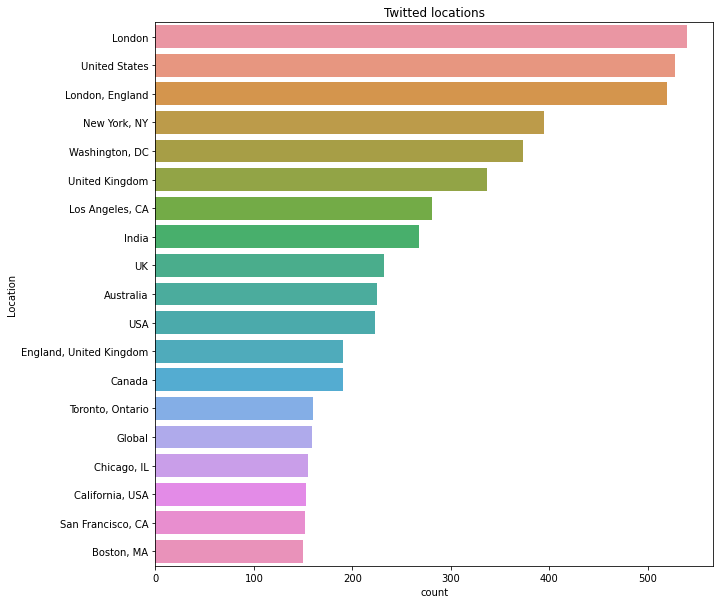

In [11]:
plt.figure(figsize=(10,10))
sns.countplot(y='Location',data=train,order=train.Location.value_counts().iloc[
    0:19].index).set_title("Twitted locations")

In [12]:
train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

Text(0, 0.5, 'Volume of Tweet')

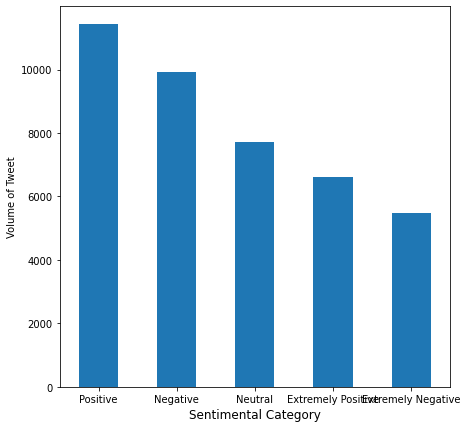

In [13]:
train.Sentiment.value_counts().plot.bar(figsize=(7,7))
plt.xticks(rotation=None)
plt.xlabel('Sentimental Category', fontsize=12)
plt.ylabel('Volume of Tweet')

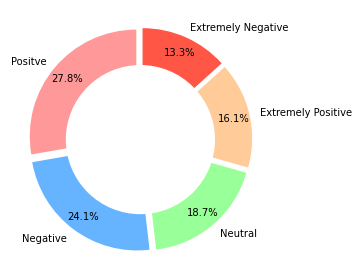

In [14]:
labels = ['Positve', 'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#ff5645']
explode = (0.05,0.05,0.05,0.05,0.05) 
plt.pie(train.Sentiment.value_counts(), colors = colors, labels=labels,
        autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
centreCircle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centreCircle)
plt.tight_layout()
plt.show()

Data Preprocessing

Both the test and train set are concatenated together to easily preprocess both together.

Training set will have an identity of 0 while the test set will have 1

In [15]:
train['Identity'] = 0
test['Identity'] = 1 
covid = pd.concat([train, test])
covid.reset_index(drop=True, inplace=True)

In [16]:
covid.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Identity
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,0
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,0
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,0
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


The 5 sentiment categories are regrouped into 3 for easy data analysis

In [17]:
covid['Sentiment'] = covid['Sentiment'].str.replace('Extremely Positive', 'Positive')
covid['Sentiment'] = covid['Sentiment'].str.replace('Extremely Negative', 'Negative')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


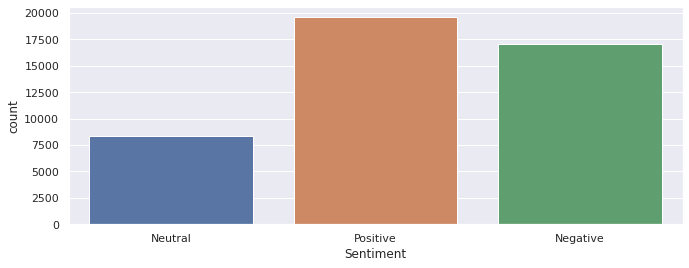

In [18]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})
sns.countplot(covid['Sentiment'])

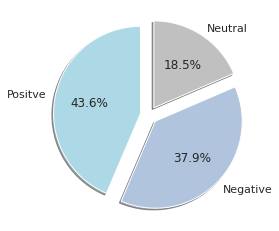

In [19]:
labels = ['Positve', 'Negative', 'Neutral']
colors = ['lightblue','lightsteelblue','silver']
explode = (0.1, 0.1, 0.1)
plt.pie(covid.Sentiment.value_counts(), colors = colors, labels=labels,
        shadow=300, autopct='%1.1f%%', startangle=90, explode = explode)
plt.show()

Text(0.5, 1.0, 'Twitted locations')

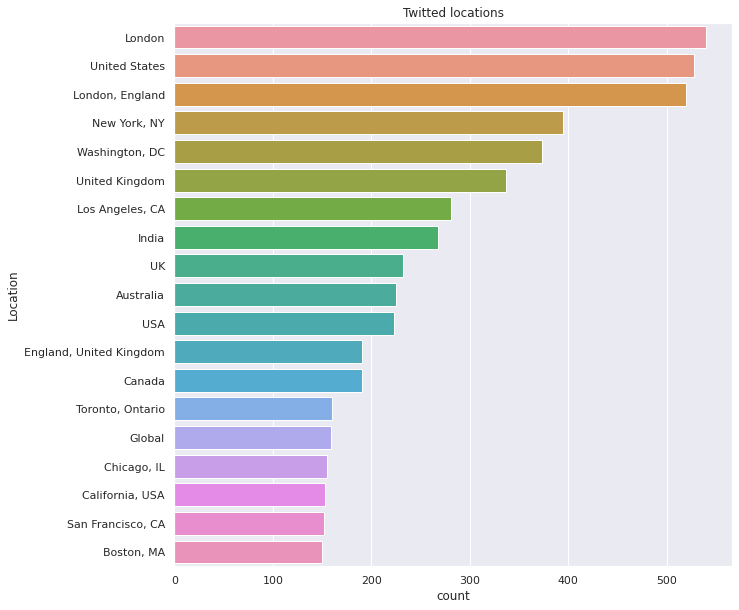

In [20]:
plt.figure(figsize=(10,10))
sns.countplot(y='Location',data=train,order=train.Location.value_counts().iloc[
    0:19].index).set_title("Twitted locations")

The blank rows in the Location column are filled with Unknown

In [21]:
covid['Location'].fillna('Unknown', inplace=True)

In [22]:
covid.isnull().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
Identity         0
dtype: int64

The sentiment categories are remapped into three so that the classifiers will be more accurate.

Neutral: 0, Positive: 1, Negative: 2

In [23]:
covid['Sentiment'] = covid['Sentiment'].map({'Neutral':0, 'Positive':1, 'Negative':2})

The screen and username columns are dropped since they'll have no effect on the accuracy of the model.

In [24]:
covid = covid.drop('ScreenName', axis=1)
covid = covid.drop('UserName', axis=1)
covid

,Location,TweetAt,OriginalTweet,Sentiment,Identity
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,0
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,1,0
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1,0
3,Unknown,16-03-2020,My food stock is not the only one which is emp...,1,0
4,Unknown,16-03-2020,"Me, ready to go at supermarket during the #COV...",2,0
...,...,...,...,...,...
44950,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,1,1
44951,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,2,1
44952,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,0,1
44953,Unknown,16-03-2020,Gov need to do somethings instead of biar je r...,2,1


A python regex function to clean the tweets by removing hashtags, mentions, urls, digits and to remove stop words.

In [25]:
import re

def clean(text):
    text = re.sub(r'http\S+', " ", text)
    text = re.sub(r'@\w+',' ',text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub('r<.*?>',' ', text)
    text = text.split()
    text = " ".join([word for word in text if not word in stopWord])
    
    return text

In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
stopWord = stopwords.words('english')

In [30]:
covid['OriginalTweet'] = covid['OriginalTweet'].apply(lambda x: clean(x))

In [31]:
covid.head()

,Location,TweetAt,OriginalTweet,Sentiment,Identity
0,London,16-03-2020,,0,0
1,UK,16-03-2020,advice Talk neighbours family exchange phone n...,1,0
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths give elderly...,1,0
3,Unknown,16-03-2020,"My food stock one empty... PLEASE, panic, THER...",1,0
4,Unknown,16-03-2020,"Me, ready go supermarket outbreak. Not I'm par...",2,0


Features not needed for the predictions are dropped

In [32]:
covid = covid[['OriginalTweet','Sentiment','Identity']]
covid.head()

,OriginalTweet,Sentiment,Identity
0,,0,0
1,advice Talk neighbours family exchange phone n...,1,0
2,Coronavirus Australia: Woolworths give elderly...,1,0
3,"My food stock one empty... PLEASE, panic, THER...",1,0
4,"Me, ready go supermarket outbreak. Not I'm par...",2,0


In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Machine learning models finds statistical relations, therefore the data is tokenized and vectorized as part of the data preprocessing step.

In [35]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [37]:
import nltk
nltk.download('wordnet')
  

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [38]:
covid['Corpus'] = [nltk.word_tokenize(text) for text in covid.OriginalTweet]
lemma = nltk.WordNetLemmatizer()
covid.Corpus = covid.apply(lambda x: [lemma.lemmatize(word) for word in x.Corpus], axis=1)
covid.Corpus = covid.apply(lambda x: " ".join(x.Corpus),axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


The data sets are splitted back into train and test set

In [39]:
train = covid[covid.Identity==0]
test = covid[covid.Identity==1]
train.drop('Identity',axis=1, inplace=True)
test.drop('Identity',axis=1, inplace=True)
test.reset_index(drop=True,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [40]:
train.head()

,OriginalTweet,Sentiment,Corpus
0,,0,
1,advice Talk neighbours family exchange phone n...,1,advice Talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths give elderly...,1,Coronavirus Australia : Woolworths give elderl...
3,"My food stock one empty... PLEASE, panic, THER...",1,"My food stock one empty ... PLEASE , panic , T..."
4,"Me, ready go supermarket outbreak. Not I'm par...",2,"Me , ready go supermarket outbreak . Not I 'm ..."


In [41]:
test.head()

,OriginalTweet,Sentiment,Corpus
0,TRENDING: New Yorkers encounter empty supermar...,2,TRENDING : New Yorkers encounter empty superma...
1,"When I find hand sanitizer Fred Meyer, I turne...",1,"When I find hand sanitizer Fred Meyer , I turn..."
2,Find protect loved ones . ?,1,Find protect loved one . ?
3,buying hits City anxious shoppers stock food&a...,2,buying hit City anxious shopper stock food & a...
4,One week everyone buying baby milk powder next...,0,One week everyone buying baby milk powder next...


The train set is splitted to get a validation set and vectorized.

In [42]:
XTrain = train.Corpus
yTrain = train.Sentiment

XTest = test.Corpus
yTest = test.Sentiment

XTrain, XVal, yTrain, yVal = train_test_split(XTrain, yTrain, test_size=0.2,random_state=42)

In [43]:
XTrain.shape, XVal.shape, yTrain.shape, yVal.shape

((32925,), (8232,), (32925,), (8232,))

In [44]:
vectorizer = CountVectorizer(stop_words='english',ngram_range=(1,2),min_df=5).fit(covid.Corpus)

XTrainVec = vectorizer.transform(XTrain)
XValVec = vectorizer.transform(XVal)
XTestVec = vectorizer.transform(XTest)

Logistic Regression Performance

In [45]:
logReg = LogisticRegression(random_state=42)

In [46]:
cross_val_score(LogisticRegression(random_state=42),
                XTrainVec, yTrain, cv=10, verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.3s finished


0.7989068918605282

In [47]:
model = logReg.fit(XTrainVec, yTrain)
print(classification_report(yVal, model.predict(XValVec)))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1553
           1       0.83      0.84      0.83      3617
           2       0.82      0.79      0.80      3062

    accuracy                           0.80      8232
   macro avg       0.78      0.79      0.78      8232
weighted avg       0.80      0.80      0.80      8232



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [52]:
print(classification_report(yTest, model.predict(XTestVec)))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       619
           1       0.78      0.81      0.80      1546
           2       0.80      0.78      0.79      1633

    accuracy                           0.77      3798
   macro avg       0.75      0.75      0.75      3798
weighted avg       0.77      0.77      0.77      3798



In [ ]:
# As expected, there is a little drop down in performance when compared with the general
# outlook of the training and validation evaluations. Fine tuning this model by using grid search
# to optimize it's parameters may give a slightly better improvement.

LONG SHORT TERM MEMORY (LSTM) MODEL

In [53]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [54]:
lines = []
for line in train['Corpus']:
    lines.append(line)
    
len(lines)

41157

DATA PREPROCESSING

The data is tokenized, turned into sequences and padded inorder to have a uniform sequence length before it's fed into the neural network

In [55]:
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(train['Corpus'].values)
wordIndex = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % (wordIndex))

Found 33411 unique tokens.


In [58]:
XTrain = tokenizer.texts_to_sequences(train['Corpus'].values)
XTrain = pad_sequences(XTrain, maxlen=1000)

XTest = tokenizer.texts_to_sequences(test['Corpus'].values)
XTest = pad_sequences(XTest, maxlen=1000)

In [59]:
XTrain.shape, XTest.shape

((41157, 1000), (3798, 1000))

In [60]:
yTrain = to_categorical(train['Sentiment'], 3)
yTest = to_categorical(test['Sentiment'], 3)

NEURAL NETWORK

The neural network consists of one embedded layer followed by one LSTM layer with 128 units. A Dropout layer is added for regularizatin to prevent overfitting of the model. The neural architecture ends with a Dense layer having three units to generate the output or prediction classes. The activation used is softmax since it is a single label, multi class problem.

In [61]:
model= models.Sequential()
model.add(layers.Embedding(wordIndex, 100, input_length=1000))
model.add(layers.LSTM(128))
model.add(Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))

In [62]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(lr=0.01),
              metrics=['accuracy'])

The callbacks parameter implemented monitors the validation loss and stops the training process once there is no apparent improvement for 10 epochs. It will also restore the best version of the model recorded during training.

In [63]:
history = model.fit(XTrain ,yTrain, batch_size=250, epochs=100, validation_split=0.2,
         callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/100
132/132 [==============================] - 31s 175ms/step - loss: 1.0167 - accuracy: 0.5009 - val_loss: 0.4547 - val_accuracy: 0.8423
Epoch 2/100
132/132 [==============================] - 23s 171ms/step - loss: 0.4285 - accuracy: 0.8569 - val_loss: 0.4138 - val_accuracy: 0.8643
Epoch 3/100
132/132 [==============================] - 22s 170ms/step - loss: 0.3428 - accuracy: 0.8851 - val_loss: 0.3957 - val_accuracy: 0.8714
Epoch 4/100
132/132 [==============================] - 23s 171ms/step - loss: 0.2804 - accuracy: 0.9077 - val_loss: 0.4200 - val_accuracy: 0.8625
Epoch 5/100
132/132 [==============================] - 23s 171ms/step - loss: 0.2199 - accuracy: 0.9242 - val_loss: 0.4947 - val_accuracy: 0.8506
Epoch 6/100
132/132 [==============================] - 23s 173ms/step - loss: 0.1768 - accuracy: 0.9400 - val_loss: 0.5574 - val_accuracy: 0.8479
Epoch 7/100
132/132 [==============================] - 23s 172ms/step - loss: 0.1331 - accuracy: 0.9544 - val_loss: 0.6331 -

VISUALIZING THE LOSS/ACCURACY OF THE MODEL IN-BEWEEN EPOCHS

Text(0.5, 0.98, 'Loss/Accuracy of the LSTM Sentiment Classifier')

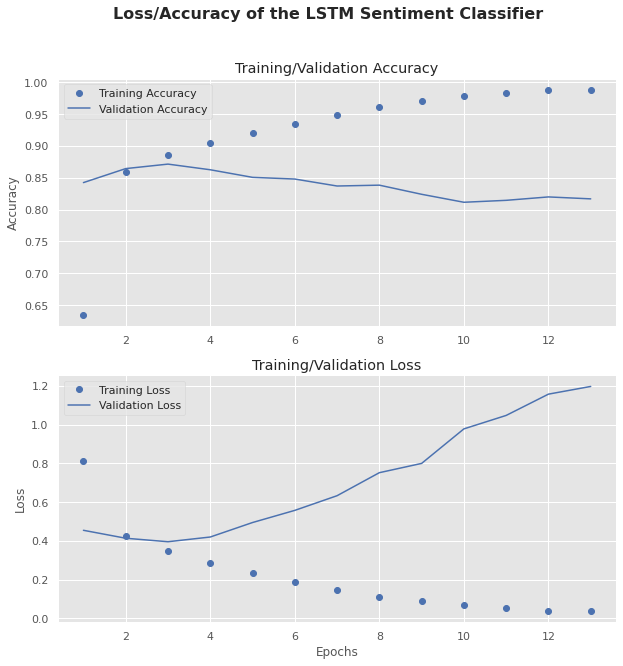

In [64]:
accuracy = history.history['accuracy']
valAccuracy = history.history['val_accuracy']
loss = history.history['loss']
valLoss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
plot = ax1.plot(epochs, accuracy, 'bo', label='Training Accuracy')
ax1.plot(epochs, valAccuracy, 'b', label='Validation Accuracy')
ax1.set(title='Training/Validation Accuracy', ylabel='Accuracy')
ax1.legend()

plot = ax2.plot(epochs, loss, 'bo', label='Training Loss')
ax2.plot(epochs, valLoss, 'b', label='Validation Loss')
ax2.set(title='Training/Validation Loss', ylabel='Loss', xlabel='Epochs')
ax2.legend()

fig.suptitle('Loss/Accuracy of the LSTM Sentiment Classifier', fontsize=16, fontweight = 'bold')

In [ ]:
# The model overfits: In the absence of more data, the overfitting being experienced can probably be
# minimized by reducing the number of layers or by reducing the number of units used in the neural
# architecture. The Dropout can also be increased. Weight regularization via the keras
# kernel_regularizer can also be implemented.

In [65]:
results = model.evaluate(XTest, yTest)

119/119 [==============================] - 2s 20ms/step - loss: 0.4529 - accuracy: 0.8407


In [ ]:
# A test accuracy score of 0.84 gives a much improved performance compared to the Logistic Regression
# algorithm. But probably can still be improved by building a better neural construct.

In [66]:
model.save('./LSTM classifier.h5')
keras.models.load_model('./LSTM classifier.h5')